In [1]:
import os
import pickle 
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import pandas as pd
from astropy.time import Time
from collections import defaultdict

sys.path.append(os.path.abspath('..'))

### Function to load in the data from the simulations that have already been run

In [4]:
def load_file(simName):
    path = os.path.join(os.getcwd(), f'data/catalogue/{simName}.pickle')
    with open(path, 'rb') as f:
        # Load the data from the pickle file
        data = pickle.load(f)
        return data

In [5]:
new_satcat = load_file('prop_original_aleph_1') #load in the catalog

In [6]:
spaceobjects = (new_satcat.Catalogue) # Select the Catalogue attribute to get just the list of SpaceObjects

In [7]:
for sat in spaceobjects:
    print(sat.altitude)

158.205
28910.531
969.192
3610.339
966.816
3464.633
3572.089
187.794
171.241
3548.213
143.954
289.999
3664.875
3619.541
3505.111
3657.346
3521.623
35748.581
3644.938
1066.626
1060.425
1060.127
991.868
458.412
315.74
596.484
572.092
585.145
3409.132
1061.461
1058.045
1057.737
1030.163
966.266
646.844
649.702
595.634
554.487
901.491
893.822
902.926
900.266
899.339
597.431
757.685
785.194
786.252
1865.957
1861.309
480.602
1041.102
1031.874
1028.571
1040.705
405.403
391.876
1038.294
804.709
769.951
829.701
807.183
810.142
791.799
403.61
382.232
146.855
35776.924
1156.046
852.162
832.131
579.388
643.176
1031.541
1046.282
867.281
964.122
1041.054
1049.638
954.739
873.067
525.208
522.8
233.38
315.041
1016.695
992.926
996.051
189.494
1016.307
994.756
787.201
876.801
704.471
703.025
146.464
2781.878
2764.15
2780.658
141.74
996.083
894.781
893.91
889.579
892.855
897.111
213.376
896.626
877.191
855.597
670.444
732.839
1270.506
1268.335
1160.114
35793.112
1443.669
924.208
559.813
235.113
929.057
2

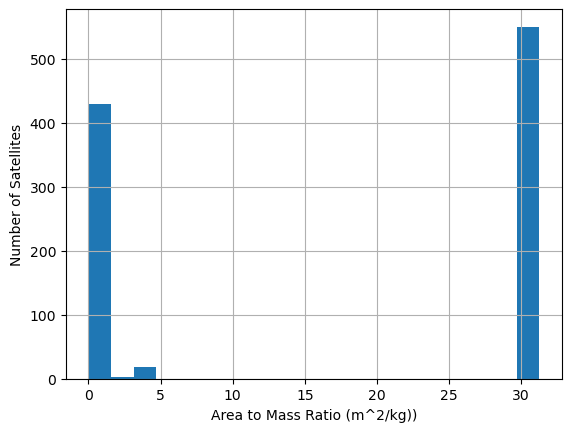

In [8]:
def area_to_mass_distribution():
    area_to_mass_ratios = []
    for sat in spaceobjects:
        area_to_mass_ratios.append(sat.characteristic_area/sat.mass)
    plt.hist(area_to_mass_ratios, bins = 20)
    plt.xlabel('Area to Mass Ratio (m^2/kg))')
    plt.ylabel('Number of Satellites')
    plt.grid()

area_to_mass_distribution()

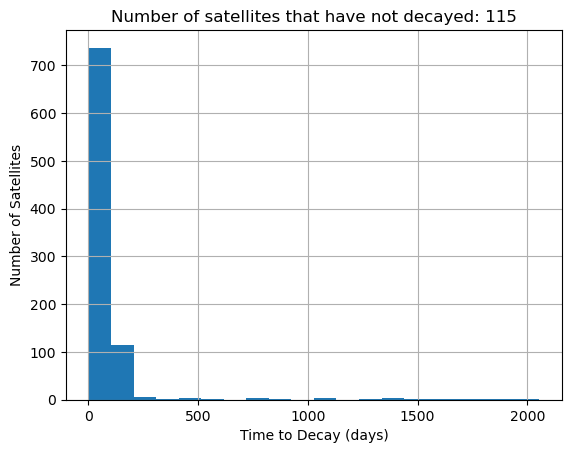

In [9]:
def time_to_decay_hist():
    #number of time steps until the altitude is less than 150km
    time_to_decay = []
    not_decayed_counter = 0
    for sat in spaceobjects:
        step_counter = 0
        for time in range(len(sat.ephemeris)):
            step_counter += 1
            if sat.ephemeris[time][1] < 150:
                time_to_decay.append(time)
                break
        else:
            not_decayed_counter += 1
    plt.hist(time_to_decay, bins = 20)
    plt.xlabel('Time to Decay (time steps)')
    plt.ylabel('Number of Satellites')
    plt.grid()
    #text displaying the number of satellites that have not decayed
    plt.title( f'Number of satellites that have not decayed: {not_decayed_counter}')


time_to_decay_hist()

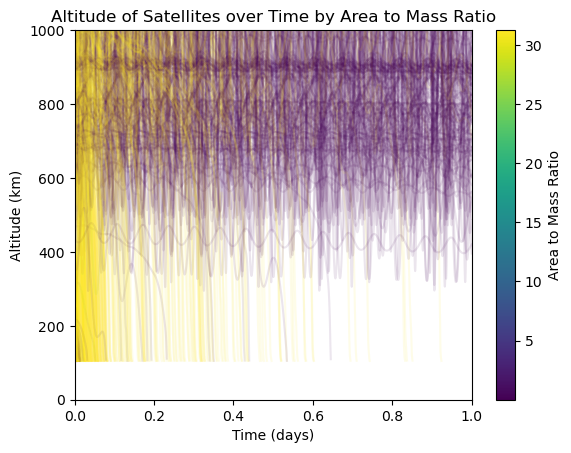

In [43]:
def decay_graphs_individual():
    for sat in spaceobjects:
        sat_altitude = []
        for time in sat.ephemeris:
            sat_altitude.append(np.linalg.norm(time[0:3])-6378.137)
        plt.plot(sat_altitude)
        plt.xlabel('Time (days)')
        plt.ylabel('Altitude (km)')
        plt.title('Altitude of Satellites over Time')
        plt.show()

import matplotlib.cm as cm
import matplotlib.colors as colors

def decay_graphs_all(time_step_seconds=20):
    # Create a color map
    cmap = cm.get_cmap('viridis')

    # Calculate area to mass ratios and get maximum for normalization
    area_to_mass_ratios = [sat.characteristic_area / sat.mass for sat in spaceobjects]
    max_ratio = max(area_to_mass_ratios)

    for i, sat in enumerate(spaceobjects):
        sat_altitude = []
        times_in_days = []
        # Normalized ratio
        normalized_ratio = area_to_mass_ratios[i] / max_ratio
        # Convert the normalized ratio to a RGBA color
        color = cmap(normalized_ratio)

        # only include those with eccentricity less than 0.01
        for j, time in enumerate(sat.ephemeris):
            sat_altitude.append(np.linalg.norm(time[0:3])-6378.137)  # altitude in km
            times_in_days.append(j * time_step_seconds / 86400)  # convert seconds to days
        plt.plot(times_in_days, sat_altitude, color=color, alpha=0.1)  # set transparency and color here

    # No need for a legend as color indicates the ratio
    plt.xlabel('Time (days)')
    plt.ylabel('Altitude (km)')
    plt.title('Altitude of Satellites over Time by Area to Mass Ratio')

    # create a scalar mappable for colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(vmin=min(area_to_mass_ratios), vmax=max_ratio))
    sm.set_array([])
    plt.colorbar(sm, label='Area to Mass Ratio')

    plt.ylim(0, 1000)
    plt.xlim(0,1)
    plt.show()

decay_graphs_all()

In [48]:
def altitude_distribution_daily(time_step=20):
    # Timesteps per day
    steps_per_day = 86400 / time_step 

    longest_ephemeris = 0
    for sat in spaceobjects:
        if len(sat.ephemeris) > longest_ephemeris:
            longest_ephemeris = len(sat.ephemeris)

    # create a list of lists to store the altitudes of each satellite for 24 hour periods
    altitudes = [[] for i in range(math.ceil(longest_ephemeris/steps_per_day))]

    # add the altitudes to the list of lists
    for sat in spaceobjects:
        for i in range(len(sat.ephemeris)):
            altitudes[math.floor(i/steps_per_day)].append(np.linalg.norm(sat.ephemeris[i][0:3]))

    print(altitudes)

    # plot the histogram for each day
    for i in range(len(altitudes)):
        if len(altitudes[i]) > 0: # add check for empty days
            plt.hist(altitudes[i], bins = 20)
            plt.xlabel('Altitude (km)')
            plt.ylabel('Number of Satellites')
            plt.title(f'Altitude Distribution for Day {i}')
            plt.grid()
            plt.show()

altitude_distribution_daily(20)

KeyboardInterrupt: 

In [34]:
#now scatter plots of the starting and ending altitudes for each satellite
def decay_scatter():
    start_altitudes = []
    end_altitudes = []
    for sat in spaceobjects:
        if sat.eccentricity < 0.1:
            start_altitudes.append(np.linalg.norm(sat.ephemeris[0][0:3])-6378.137)
            end_altitudes.append(np.linalg.norm(sat.ephemeris[-1][0:3])-6378.137)
        #xlim = (0, 10000)
        #ylim = (0, 10000)
        #plot a 1:1 line
    plt.plot([0, 10000], [0, 10000], color='black', linestyle='--', linewidth=1)
    plt.xlim(0, 2000)
    plt.ylim(0, 2000)
    plt.grid()
    plt.scatter(start_altitudes, end_altitudes, s=1, alpha=0.5)
    plt.xlabel('Starting Altitude (km)')
    plt.ylabel('Ending Altitude (km)')
    plt.title('Starting and Ending Altitudes of Satellites')
    plt.show()

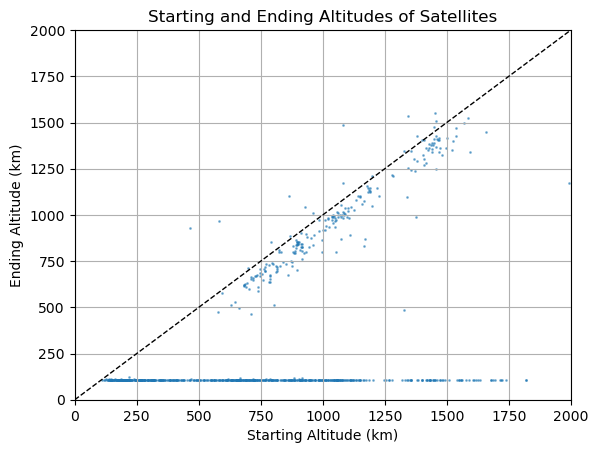

In [35]:
decay_scatter()

In [6]:
#attributes of a spaceobject
spaceobjects[0].__dict__.keys()

dict_keys(['launch_date', 'decay_date', 'rso_name', 'rso_type', 'payload_operational_status', 'object_type', 'application', 'operator', 'characteristic_length', 'characteristic_area', 'mass', 'source', 'launch_site', 'maneuverable', 'spin_stabilized', 'apogee', 'perigee', 'propulsion_type', 'epoch', 'day_of_year', 'station_keeping', 'tle', 'ephemeris', 'sma', 'orbital_period', 'inc', 'argp', 'raan', 'tran', 'eccentricity', 'meananomaly', 'altitude', 'cart_state', 'C_d'])

In [20]:
#number of objects with eccentricity > 0.1
# Currently: 3495
# these are problematic as we use perigee == altitude, but for non-ciruclar orbits this assumption is not valid and leads to issues with decay etc.
eccentricity = []
for i in range(len(spaceobjects)):
    eccentricity.append(spaceobjects[i].eccentricity)

eccentricity = np.array(eccentricity)
eccentricity[eccentricity > 0.1].shape

print("Number of objects with eccentricity > 0.1: ", eccentricity[eccentricity > 0.1].shape[0])

Number of objects with eccentricity > 0.1:  72


### BStar
This is how I got the median value of BStar to run the simulation with

In [38]:
def launch_date_histogram(spaceobjects):
    launch_dates = []
    for sat in spaceobjects:
        launch_dates.append(sat.launch_date)
    plt.hist(launch_dates, bins=100)
    plt.xlabel('Launch Date')
    plt.ylabel('Number of Satellites')
    plt.show()

In [39]:
def decay_date_histogram(spaceobjects):
    decay_dates = []
    never_decayed = 0
    for sat in spaceobjects:
        #if decay date is after 2999, 1, 1, this means it never decayed
        if sat.decay_date > datetime.datetime(2998, 1, 1):
            never_decayed += 1
        else:
            decay_dates.append(sat.decay_date)

    plt.hist(decay_dates, bins=100)
    plt.xlabel('Decay Date')
    #set xlim from 1960-2029
    plt.ylabel('Number of Satellites')
    print("Number of satellites that never decayed: ", never_decayed)
    plt.show()

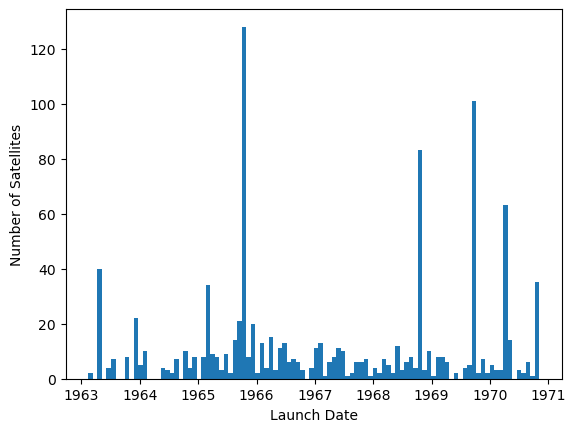

In [40]:
launch_date_histogram(spaceobjects)

Number of satellites that never decayed:  728


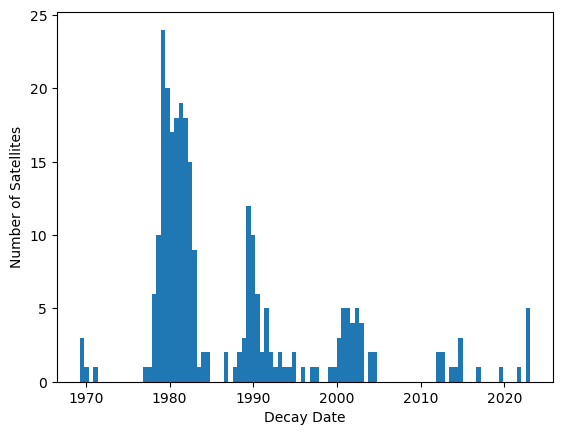

In [41]:
decay_date_histogram(spaceobjects)

### Orbital Highway Plots (inspired by Jah and McDowell Paper(reference))

In [13]:
def orbital_highway_plot(spaceobjects):
    for i in range(0,15, 1):
        new_altitudes = []
        for satellite in spaceobjects:
            if satellite.eccentricity < 0.1:
                try: 
                    new_altitudes.append(np.linalg.norm(satellite.ephemeris[i][-1]) - 6378) # take the last emepheris point
                except:
                    continue

        y_values = [random.random() for i in range(len(new_altitudes))]        
        plt.scatter(new_altitudes, y_values, alpha=0.5, s=0.1)
        plt.xlim(0, 2000)
        plt.xlabel('Altitude (km)')
        plt.ylabel('Random Value')
        plt.show()

### Check the starting vs ending altitude of all the satellites in the catalog. 
This is to see how they decay as a function of initial conditions

### Altitude time series plot for all satellites
This is a sanity check on the decay rates of the satellites

In [20]:
def altitude_tseries(spaceobjects):
    array_of_tseries = []
    array_of_bstars = [] # area of the satellite
    array_of_unplotted_sats = []
    for satellite in spaceobjects:
        if satellite.eccentricity < 0.1:
            altitude_tseries = [np.linalg.norm(satellite.ephemeris[i][1]) - 6371.137 for i in range(len(satellite.ephemeris))]
            if altitude_tseries:  # Check if list is not empty
                array_of_tseries.append(altitude_tseries)
            else:
                array_of_unplotted_sats.append(satellite)

    # Select every 10th satellite in the array
    array_of_tseries = array_of_tseries
    print("plotting ", len(array_of_tseries), " satellites")

    plt.figure(figsize=[10,8])
    for alt_series in array_of_tseries:
        # Plot altitude time series and color the points as function of area
        plt.plot(range(len(alt_series)), alt_series, color='xkcd:jungle green', alpha=0.2)

    plt.xlabel('Months from start of simulation')
    plt.ylabel('Altitude (km)')
    plt.title('Altitude Time Series')
    plt.show()

plotting  86  satellites


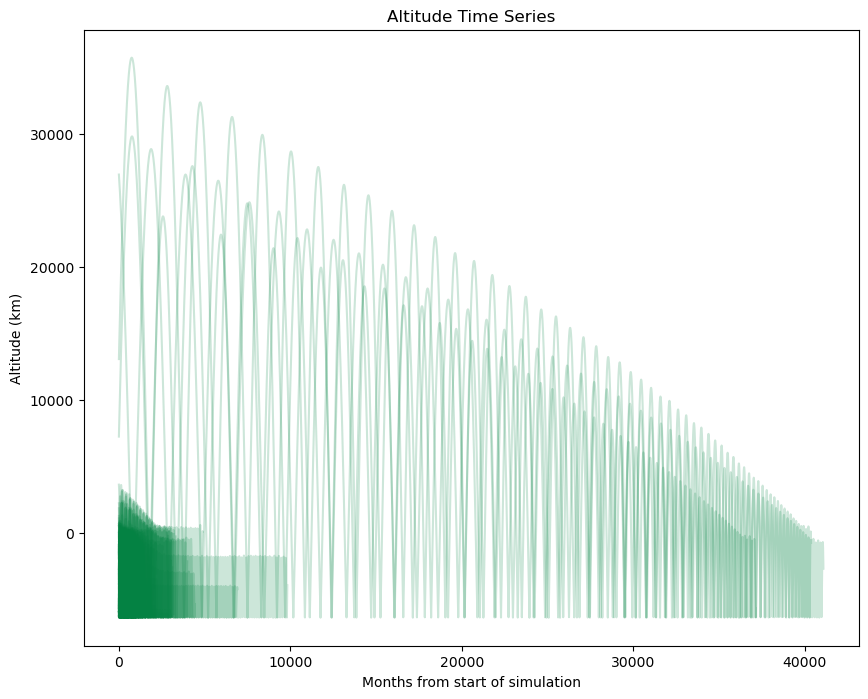

number of satellites:  100


In [21]:
# To use the function:
altitude_tseries(spaceobjects)
print("number of satellites: ", len(spaceobjects))

### Histogram of satellite areas in the catalog 
This allows us to infer what the predominant type is and serves as a sanity check

In [132]:
def area_hist(data):
    array_of_areas = [] # area of the satellite
    zero_area_count = 0
    for satellite in data:
        # if satellite.eccentricity > 0.1:
            area = satellite.characteristic_area
            array_of_areas.append(area)
            if area == 0:
                zero_area_count += 1
    print("zero area count: ", zero_area_count)
    plt.hist(array_of_areas, bins=100)
    plt.xlabel('Area (m^2)')
    plt.ylabel('Number of Satellites')
    plt.show()

In [57]:
SATCAT_after_prop = load_file('SATCAT_after_prop_optimistic')
for satellite in SATCAT_after_prop:
    try: 
        satellite.altitude = np.linalg.norm(satellite.ephemeris[-1][1]) - 6378 # take the last emepheris point
    except:
        continue

df = pd.DataFrame([vars(obj) for obj in SATCAT_after_prop])


In [61]:
df[(df['altitude'] >= 200) & (df['altitude'] <= 300) & (df['decay_date'].isna())]

,CATID,GUID,launch_date,decay_date,cospar_id,rso_name,rso_type,payload_operational_status,object_type,application,...,tran,eccentricity,meananomaly,altitude,atmos_density,C_d,bstar,no_kozai,sgp4epoch,cart_state
227,None,04a38ab1-f53d-4ab6-b2b7-44e193a24203,1961-06-29,NaT,1961-015CE,THOR ABLESTAR DEB,None,None,DEBRIS,Unknown,...,3.579865,0.003185,2.700611,236.578792,1.000000e-35,2.2,2.58730e-03,14.666344,26779,None
566,None,8f3b686f-030b-4b78-93de-3212c8fc9fd8,1963-06-27,NaT,1963-025B,HITCH HIKER 1,None,None,PAYLOAD,Unknown,...,1.505614,0.039138,1.427674,280.478127,1.000000e-35,2.2,6.18500e-04,15.016534,26778,None
2232,None,ddbdb460-cee0-474f-82ef-0ea4ae9d328a,1965-10-15,NaT,1965-082KR,TITAN 3C TRANSTAGE DEB,None,None,DEBRIS,Unknown,...,5.320287,0.009277,0.947728,269.113352,1.000000e-35,2.2,2.57480e-03,14.715777,26778,None
2784,None,f481dee9-338a-4291-8b9a-bb1f53bda2d5,1965-10-15,NaT,1965-082MY,TITAN 3C TRANSTAGE DEB,None,None,DEBRIS,Unknown,...,2.318190,0.000879,2.316900,295.243891,1.000000e-35,2.2,1.33560e-03,14.863556,26777,None
3486,None,23122761-939c-47be-9858-9f69ba507c75,1969-09-30,NaT,1969-082CP,THORAD AGENA D DEB,None,None,DEBRIS,Unknown,...,5.524347,0.003336,0.754256,265.640663,1.000000e-35,2.2,1.81480e-03,14.786135,26778,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54589,None,6d2526aa-3522-415b-9f18-4c3518166a52,None,NaT,UNKNOWN,TBA - TO BE ASSIGNED,None,None,UNKNOWN,Unknown,...,4.332257,0.005748,1.940237,213.792937,1.000000e-35,2.2,3.64000e-03,14.865168,26776,None
54590,None,3c7a4a78-347d-4f6d-bd6f-a13e6b7b5e7b,None,NaT,UNKNOWN,TBA - TO BE ASSIGNED,None,None,UNKNOWN,Unknown,...,5.147511,0.003257,1.129774,244.245012,1.000000e-35,2.2,2.02060e-03,15.023726,26358,None
54689,None,2c09cad5-79a5-4416-a99b-e663e805d9f7,None,NaT,UNKNOWN,TBA - TO BE ASSIGNED,None,None,UNKNOWN,Unknown,...,2.906017,0.004963,2.903692,231.367478,1.000000e-35,2.2,2.83220e-03,14.641171,26772,None
54863,None,636752c2-347b-4310-8fea-c1107b9f9b27,None,NaT,UNKNOWN,TBA - TO BE ASSIGNED,None,None,UNKNOWN,Unknown,...,3.792360,0.014967,2.472528,212.136302,1.000000e-35,2.2,9.70727e-03,14.198879,26777,None


In [ ]:
total = 0
for sat in SATCAT_after_prop:
    try:
        val = float(sat.mass)
        if val > 0:
            total += val
    except:
        continue

print(total)

49889197.92300162


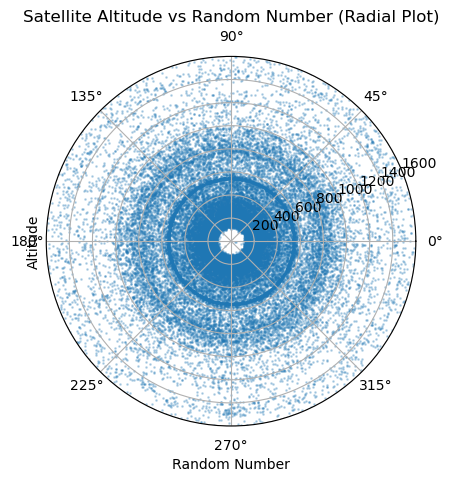

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Sample data
y_values = [random.random() for _ in data]
altitudes = [satellite.altitude for satellite in data]

# Convert altitude and y values to polar coordinates
r = altitudes
theta = 2 * np.pi * np.array(y_values)

# Create a polar scatter plot
ax = plt.subplot(111, projection='polar')
ax.scatter(theta, r, s=1, alpha=0.25)

# Set the radial axis limit
ax.set_rlim(0, 1600)

# Add labels and title to the plot
ax.set_xlabel('Random Number')
ax.set_ylabel('Altitude')
ax.set_title('Satellite Altitude vs Random Number (Radial Plot)')

# Display the plot
plt.show()


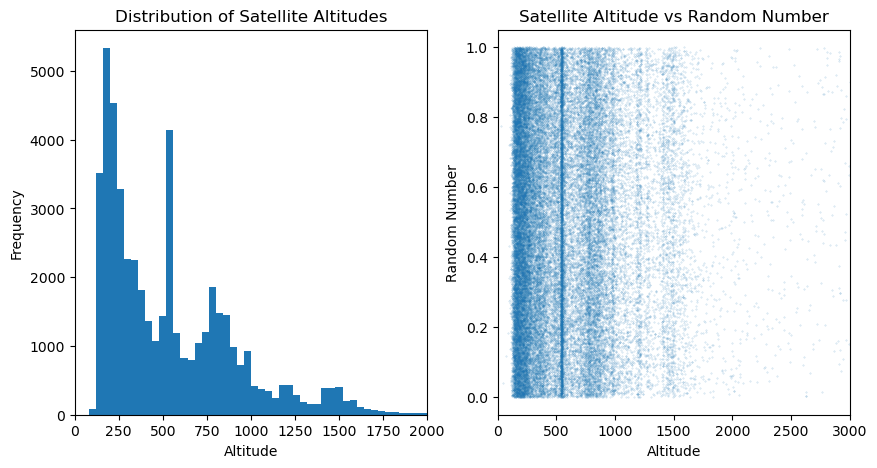

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
y_values = [random.random() for _ in SATCAT_after_prop]

altitudes = [satellite.altitude for satellite in SATCAT_after_prop]
# Create a histogram of the altitudes
ax1.hist(altitudes, bins=50, range=(0, 2000))

# Add labels and title to the plot
ax1.set_xlabel('Altitude')
ax1.set_ylabel('Frequency')
ax1.set_xlim(0, 2000)
ax1.set_title('Distribution of Satellite Altitudes')

# Plot the second chart on the second subplot
ax2.scatter(altitudes, y_values, s=0.1, alpha=0.3)

# Add labels and title to the plot
ax2.set_xlabel('Altitude')
ax2.set_ylabel('Random Number')
ax2.set_xlim(0, 3000)
ax2.set_title('Satellite Altitude vs Random Number')

# Display the plot
plt.show()

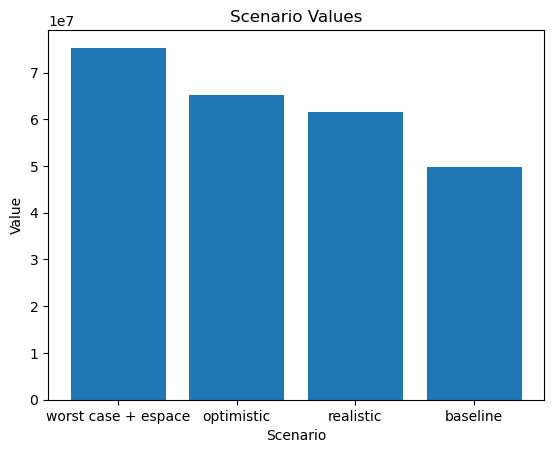

In [ ]:
data = {"worst case + espace": 75305977.92300162, "optimistic": 65264154.92300162, "realistic": 61552853.92300162, "baseline": 49889197.92300162}

# Create a bar chart
plt.bar(data.keys(), data.values())

# Add labels and title to the plot
plt.xlabel('Scenario')
plt.ylabel('Value')
plt.title('Scenario Values')

# Display the plot
plt.show()

### Orbital Density

Firstly, calculate the volume of the entire orbital shell, and then the total volume of all space objects at one given time. 

In [ ]:
orbital_shells = {}
orbital_shells_volume = {}

for i in range(0, 2001, 100):
    # Add a key-value pair to the dictionary
    orbital_shells[i] = 0
    orbital_shells_volume[i] = 0

for obj in SATCAT_after_prop:
    altitude = obj.altitude
    shell = math.ceil(altitude / 100) * 100 # get the nearest 100km shell
    # increase the value in the dictionary by 1 where the shell and key are the same
    if shell in orbital_shells:
        orbital_shells[shell] += 1


x = list(orbital_shells.keys())
y = list(orbital_shells.values())

plt.plot(x, y)
plt.xlabel('Orbital shell')
plt.ylabel('Number of objects')
plt.title('Number of objects in each orbital shell')
plt.show()

NameError: name 'SATCAT_after_prop' is not defined

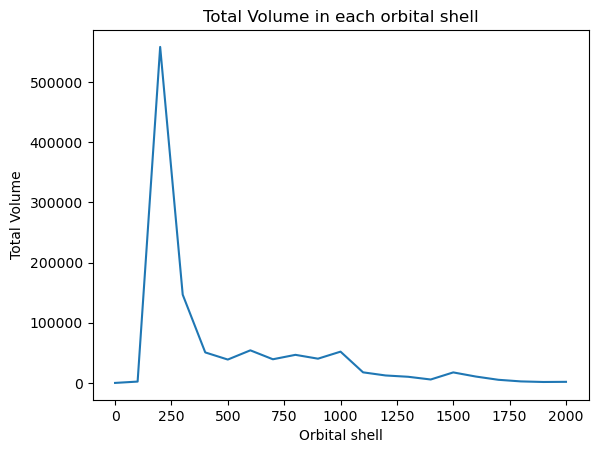

{0: 0,
 100: 2229.269999999999,
 200: 558058.9199999674,
 300: 146597.5800000364,
 400: 50658.95999999876,
 500: 38811.44999999926,
 600: 54120.20999999837,
 700: 39290.48999999944,
 800: 46645.529999999126,
 900: 40260.80999999912,
 1000: 51936.269999999546,
 1100: 17568.299999999766,
 1200: 12377.909999999803,
 1300: 10210.139999999836,
 1400: 5685.4799999999905,
 1500: 17468.879999999815,
 1600: 10597.679999999946,
 1700: 5203.169999999987,
 1800: 2518.2600000000066,
 1900: 1557.5999999999992,
 2000: 1810.4399999999976}

In [ ]:
# calculate the mass in each orbital shell
for obj in SATCAT_after_prop:
    altitude = obj.altitude
    shell = math.ceil(altitude / 100) * 100 # get the nearest 100km shell
    # increase the value in the dictionary by 1 where the shell and key are the same
    if shell in orbital_shells_volume:
        orbital_shells_volume[shell] += obj.characteristic_area * obj.characteristic_length

x = list(orbital_shells_volume.keys())
y = list(orbital_shells_volume.values())

plt.plot(x, y)
plt.xlabel('Orbital shell')
plt.ylabel('Total Volume')
plt.title('Total Volume in each orbital shell')
plt.show()
orbital_shells_volume


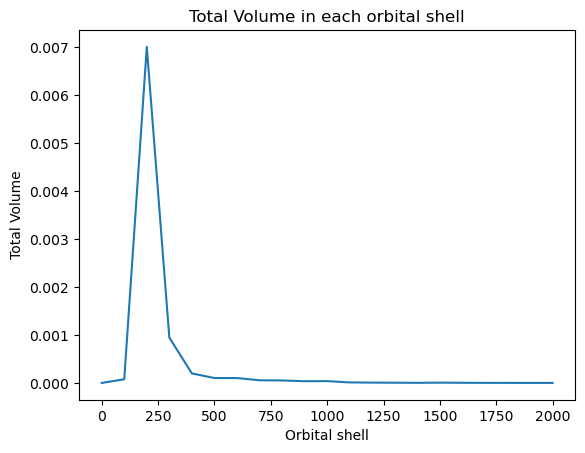

{0: 0,
 100: 2229.269999999999,
 200: 558058.9199999674,
 300: 146597.5800000364,
 400: 50658.95999999876,
 500: 38811.44999999926,
 600: 54120.20999999837,
 700: 39290.48999999944,
 800: 46645.529999999126,
 900: 40260.80999999912,
 1000: 51936.269999999546,
 1100: 17568.299999999766,
 1200: 12377.909999999803,
 1300: 10210.139999999836,
 1400: 5685.4799999999905,
 1500: 17468.879999999815,
 1600: 10597.679999999946,
 1700: 5203.169999999987,
 1800: 2518.2600000000066,
 1900: 1557.5999999999992,
 2000: 1810.4399999999976}

In [ ]:
volumes = {}
for shell in orbital_shells_volume:
    r1 = shell
    r2 = shell + 100
    volume = (4/3) * math.pi * (r2**3 - r1**3)
    density = orbital_shells_volume[shell] / volume
    volumes[shell] = density

x = list(volumes.keys())
y = list(volumes.values())

plt.plot(x, y)
plt.xlabel('Orbital shell')
plt.ylabel('Total Volume')
plt.title('Total Volume in each orbital shell')
plt.show()
orbital_shells_volume

### Vis-Viva Law
The vis-viva equation is a formula that relates the velocity of a spacecraft in orbit around a celestial body to the distance between the spacecraft and the body, as well as the mass of the body.

In [ ]:
total = 0
for obj in SATCAT_after_prop:
    # calcaulate the vis-viva equation
    gravity = 398600.4418
    v = math.sqrt(398600.4418 * obj.mass / (obj.altitude + 6378))

Vis-Viva law over time

In [33]:
years = ['2023', '2024', '2025', '2026', '2027', '2028']

# Convert the data list to a dataframe
df = pd.DataFrame([obj.__dict__ for obj in data])

# Loop through each satellite object in the dataframe
for i, row in df.iterrows():
    # Check the length of the ephemeris and the decay date
    if len(row['ephemeris']) == 6 and (pd.isna(row['decay_date'])):
        # Loop through each sub-list in the ephemeris list
        for j, ephemeris_point in enumerate(row['ephemeris']):
            # Compute the altitude for the current ephemeris point
            altitude = np.linalg.norm(ephemeris_point[1]) - 6378

            # Add the altitude to a new column in the dataframe
            year = years[j % len(years)]
            column_name = f'altitude_{year}'
            df.at[i, column_name] = altitude

In [34]:
df.head()

,CATID,GUID,launch_date,decay_date,cospar_id,rso_name,rso_type,payload_operational_status,object_type,application,...,bstar,no_kozai,sgp4epoch,cart_state,altitude_2023,altitude_2024,altitude_2025,altitude_2026,altitude_2027,altitude_2028
0,None,c36232d7-0b63-4ca9-bfe8-b02c14c7e93f,None,1970-03-31,1958-001A,EXPLORER 1,None,None,PAYLOAD,Unknown,...,0.00000e+00,16.275443,7395,None,NaN,NaN,NaN,NaN,NaN,NaN
1,None,3487fc86-9bec-4c07-8fc0-04556c2f7d72,1958-03-17,NaT,1958-002B,VANGUARD 1,None,None,PAYLOAD,Unknown,...,9.50240e-05,10.850798,26778,None,954.766252,2701.867823,3691.258457,3445.017231,1194.152977,3281.443111
2,None,129225be-af6c-4880-89ce-f9a6b07ba5b1,None,1960-04-06,1958-004B,SPUTNIK 3,None,None,PAYLOAD,Unknown,...,0.00000e+00,16.283259,3747,None,NaN,NaN,NaN,NaN,NaN,NaN
3,None,92a2fffe-a35f-4668-8f6d-cbe52d758bf0,None,1959-10-23,1958-005A,EXPLORER 4,None,None,PAYLOAD,Unknown,...,0.00000e+00,15.516105,3562,None,NaN,NaN,NaN,NaN,NaN,NaN
4,None,d1f67b02-8c8a-4631-83e7-b3bd4647fff9,1959-02-17,NaT,1959-001A,VANGUARD 2,None,None,PAYLOAD,Unknown,...,1.47020e-03,11.870405,26778,None,2853.737382,567.421068,904.906985,565.219197,694.318404,608.178252


### Final Calculations and Comparisons to Other Models
Here in the results folder, is all of the previous models that have been run. This code here will compare and analyse each of their results. 

1. A 4x4 comparison plot of the orbital highways. 
2. A 4x4 comparison radio plot of the orbital highways.
3. A policy breakdown of the vis-visa law. 
4. A policy breakdown of the orbital spatial density.

In [ ]:
# import os
# import pickle
# import random
# import matplotlib.pyplot as plt

# def get_alitudes(simName):
#     sys.path.append('D:/UCL/FSPSimulator')
#     with open(os.path.join(os.getcwd(), f'../../src/data/catalogue/{simName}'), 'rb') as f:
#         # Load the data from the pickle file
#         data = pickle.load(f)
        
#     altitudes = [satellite.altitude for satellite in data]
#     y_values = [random.random() for i in range(len(altitudes))]
#     output = zip(altitudes, y_values, simName)
#     print(output)
#     return output

# # define the list of simNames
# simNames = ['SATCAT_after_prop_optimistic.pickle', 'SATCAT_after_prop_realistic.pickle',
#             'SATCAT_after_prop_worst_case.pickle', 'SATCAT_after_prop_baseline.pickle']

# all_altitudes = []
# for simName in simNames:
#     altitudes.append(get_alitudes(simName))

In [53]:
orbital_shells_vis_viva = []
orbital_shells_density = []
total_vis_viva = []
orbital_shells = {}
orbital_shells_volume = {}
for i in range(0, 2001, 100):
    # Add a key-value pair to the dictionary
    orbital_shells[i] = 0
    orbital_shells_volume[i] = 0


def get_alitudes(simName):
    with open(f'D:/UCL/FSPSimulator/src/data/catalogue/{simName}', 'rb') as f:
        # Load the data from the pickle file
        data = pickle.load(f)

    for satellite in data:
        try: 
            satellite.altitude = np.linalg.norm(satellite.ephemeris[0][1]) - 6378 # take the last emepheris point
        except:
            continue
        
    altitudes = [satellite.altitude for satellite in data if pd.isna(satellite.decay_date) or satellite.decay_date > datetime.datetime(2028, 12, 31) and satellite.decay_date < datetime.datetime(2030, 1, 1)]
    y_values = [random.random() for i in range(len(altitudes))]
    output = [altitudes, y_values]

    temp = {}
    density_temp = {}
    vis_viva_total = 0

    # also calculate the vis viva equation
    for i in range(0, 2001, 100):
        # Add a key-value pair to the dictionaries
        temp[i] = 0
    for obj in data:
        shell = math.ceil(obj.altitude / 100) * 100 # get the nearest 100km shell
        
        # increase the value in the dictionary by 1 where the shell and key are the same
        if shell in orbital_shells:            
            # calculate vis viva and add to the value in the dictionary
            gravity = 398600.4418
            if math.isnan(obj.mass):
                vis_viva = math.sqrt(gravity * 12 / (obj.altitude + 6378))
            else:
                vis_viva = math.sqrt(gravity * obj.mass / (obj.altitude + 6378))
            temp[shell] += vis_viva
            vis_viva_total += vis_viva
    
    # then based on the temp shells, calculate the total spatial density
    for shell in temp:
        r1 = shell
        r2 = shell + 100
        volume = (4/3) * math.pi * (r2**3 - r1**3)
        density = temp[shell] / volume
        density_temp[shell] = density
    
    orbital_shells_vis_viva.append(temp)
    orbital_shells_density.append(density_temp)
    total_vis_viva.append([simName, vis_viva_total])

    return output

# define the list of simNames
simNames = ['SATCAT_after_prop_baseline.pickle', 'SATCAT_after_prop_realistic.pickle',
            'SATCAT_after_prop_optimistic.pickle', 'SATCAT_after_prop_worst_case.pickle']
all_altitudes = []
for simName in simNames:
    all_altitudes.append(get_alitudes(simName))

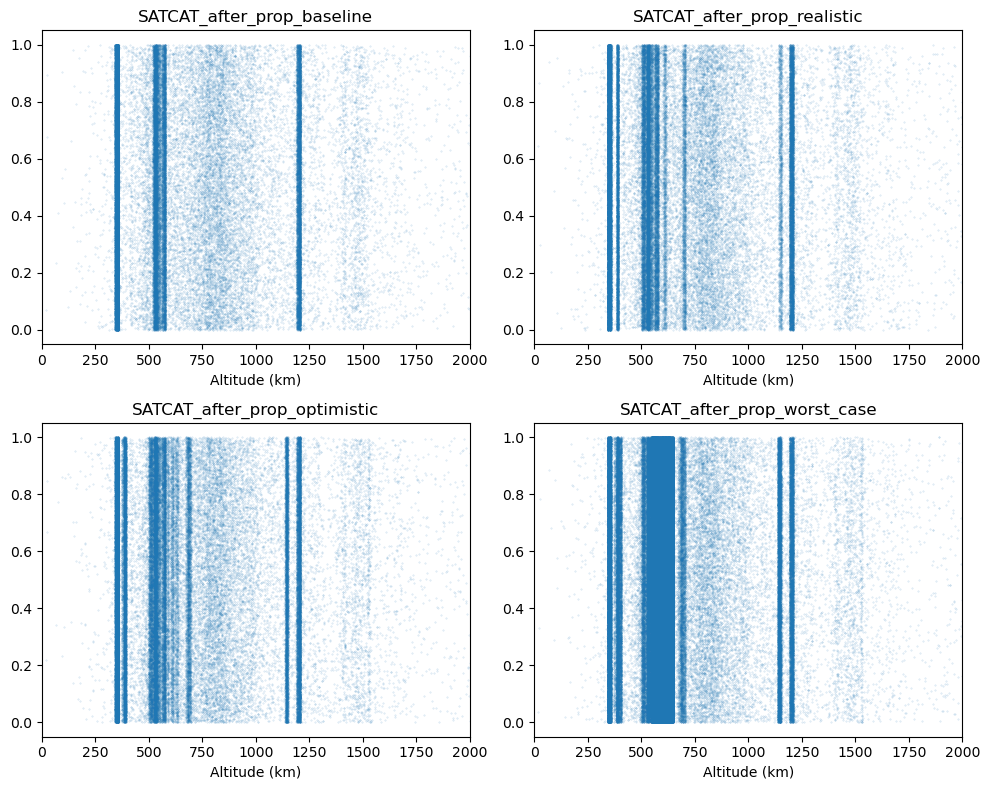

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i in range(2):
    for j in range(2):
        idx = 2*i+j
        x, y = all_altitudes[idx][0], all_altitudes[idx][1]
        axs[i, j].scatter(x, y, alpha=0.25, s=0.1)
        axs[i, j].set_xlim(0, 2000)
        axs[i, j].set_xlabel('Altitude (km)')
        axs[i, j].set_title(simNames[idx].replace('.pickle', ''))

plt.tight_layout()
plt.show()

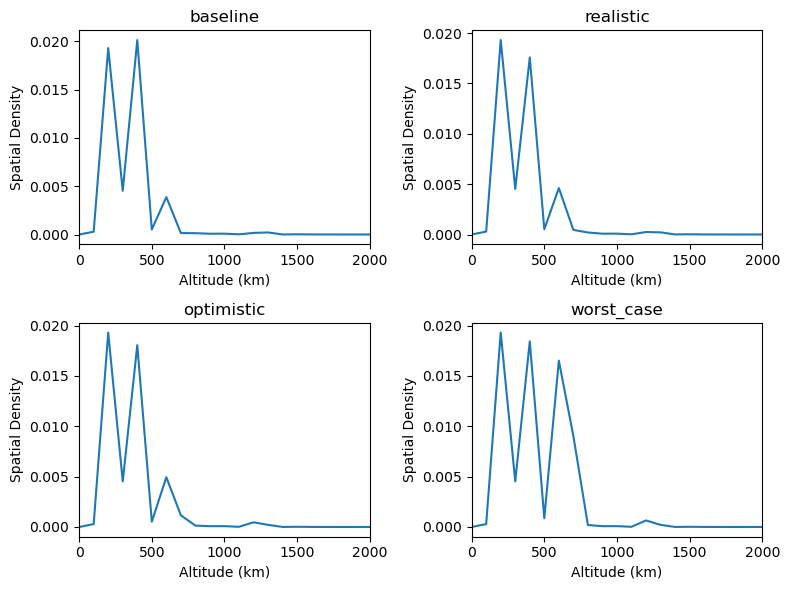

In [55]:
# Create a 2 x 2 plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# Loop through the list of dictionaries and plot a line graph for each
for i in range(len(orbital_shells_density)):
    x = list(orbital_shells_density[i].keys())
    y = list(orbital_shells_density[i].values())
    axs[i // 2, i % 2].plot(x, y)
    axs[i // 2, i % 2].set_title(f'{simNames[i].replace(".pickle", "").replace("SATCAT_after_prop_", "")}')
    axs[i // 2, i % 2].set_xlabel('Altitude (km)')
    axs[i // 2, i % 2].set_ylabel('Spatial Density')
    axs[i // 2, i % 2].set_xlim(0, 2000)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

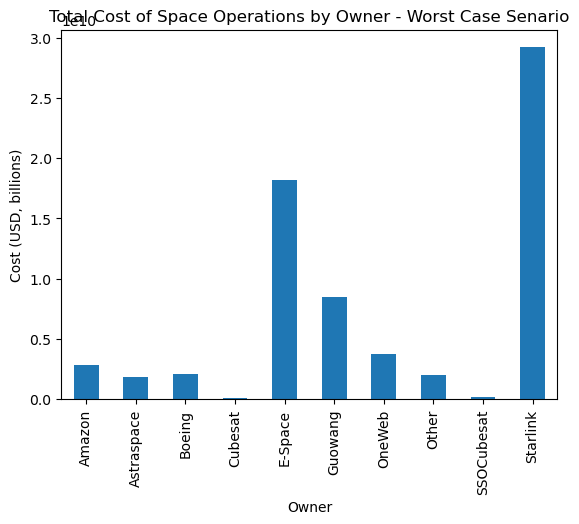

In [56]:
# plot economic scenarios
import pandas as pd
df = pd.read_csv('D:/UCL/FSPSimulator/src/data/results/SATCAT_after_prop_worst_case.csv')


grouped = df.groupby('_owner').sum()

ax = grouped.plot(kind='bar', y='total_cost', legend=None)

# Set the labels for the x and y axes and the title of the plot
ax.set_xlabel('Owner')
ax.set_ylabel('Cost (USD, billions)')
ax.set_title('Total Cost of Space Operations by Owner - Worst Case Senario')

# Show the plot
plt.show()



##